In [1]:
import SoapySDR
from SoapySDR import * #SOAPY_SDR_ constants
import numpy as np
import matplotlib.pyplot as plt
import pyModeS as pms

In [2]:
results = SoapySDR.Device.enumerate()
for result in results: print(result)

{driver=rtlsdr, label=Generic RTL2832U OEM :: 00000001, manufacturer=Realtek, product=RTL2838UHIDIR, serial=00000001, tuner=Rafael Micro R820T}


Found Rafael Micro R820T tuner


In [3]:
args = dict(driver="rtlsdr")
sdr = SoapySDR.Device(args)

[INFO] Opening Generic RTL2832U OEM :: 00000001...
Found Rafael Micro R820T tuner


In [4]:
freqs = sdr.getFrequencyRange(SOAPY_SDR_RX, 0)
for freqRange in freqs: print(freqRange)

2.3999e+07, 1.764e+09


In [5]:
sdr.setSampleRate(SOAPY_SDR_RX, 0, 2e6)
sdr.setFrequency(SOAPY_SDR_RX, 0, 1090e6)

Exact sample rate is: 2000000.052982 Hz
[R82XX] PLL not locked!


In [15]:
def record_samples():
    rxStream = sdr.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CF32)
    sdr.activateStream(rxStream)

    buff = np.array([0]*125000, np.complex64)
    sr = sdr.readStream(rxStream, [buff], len(buff))
    
    sdr.deactivateStream(rxStream)
    sdr.closeStream(rxStream)

    return buff

[INFO] Using format CF32.


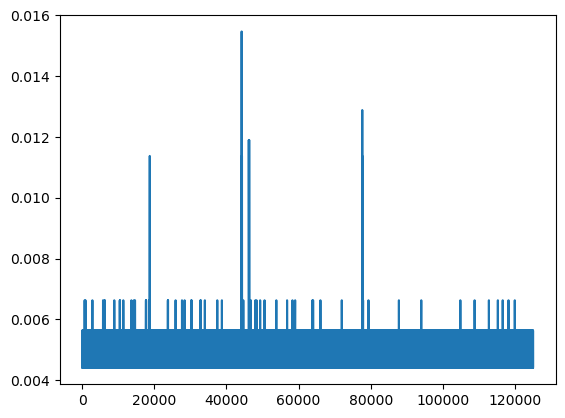

In [41]:
while True:
    samples = record_samples()
    y = np.abs(samples)
    if np.max(y) > 0.01:
        break

plt.plot(y)
plt.show()

In [42]:
def bool2Hex(lst):
    tmp =  ''.join(['1' if x else '0' for x in lst])
    return hex(int(tmp,2))[2:]

In [43]:
# Calculate mean and standard deviation of samples to identify noise floor
y_mean = np.mean(y)
print(y_mean)
y_std=np.std(y)
print(y_std)

0.0044817594
0.00033789084


In [44]:
# Set noise floor and identify all samples above noise floor
alpha = 5
sig_thresh = y_mean + alpha*y_std
idx_sig = np.nonzero(y > sig_thresh)[0]
print(sig_thresh)
print(len(idx_sig))

0.006171213608467951
204


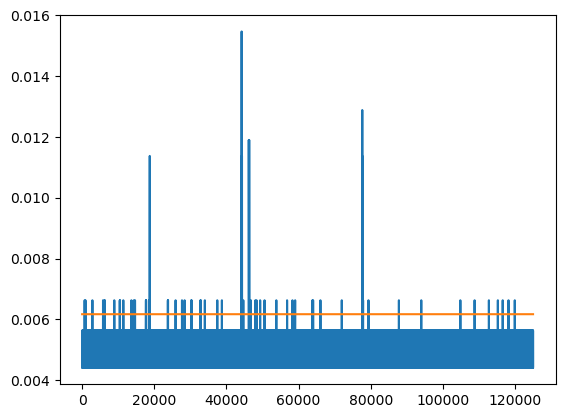

In [45]:
plt.plot(y)
plt.plot([sig_thresh]*len(y))
plt.show()

In [46]:
def detectPreambleXcorr(chunk,corrthresh):    
    preamble = np.array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]) 

    chunk_mean = np.mean(chunk)
    c = np.array(chunk) - chunk_mean
    b = c * preamble
    numerator = np.sum(b)         
    
    a1 = np.linalg.norm(c)            
    a2 = np.linalg.norm(preamble)      
    
    denominator = a1*a2
    
    crossCorr = numerator/denominator

    if (crossCorr>corrthresh):
        return 1              #True = 1.  Returns true if the calculated crossCorr is greater than corrthresh
    else:
        return 0         

In [47]:
idx_corr = []

for n in idx_sig:
    x = abs(y[n:n+16])
    a = detectPreambleXcorr(x,0.5)
    if a == 1:
        idx_corr.append(n)

print ('idx_corr are ' , idx_corr)
print ('length of idx_corr is',len(idx_corr))

idx_corr are  [2843, 14660, 23786, 30322, 44191, 44306, 44308, 44310, 44315, 46191, 50563, 59049]
length of idx_corr is 12


In [48]:
msgs = []
for i in range(len(idx_corr)):
    msgs.append(abs(y[idx_corr[i]:idx_corr[i]+16+112*2]))

msgs = np.vstack(msgs)
msgs.shape

(12, 240)

In [49]:
count=0
for n in range(msgs.shape[0]):
    # Mask because on-off keying
    bits = msgs[n,16::2] > msgs[n,17::2]
    msg = bool2Hex(bits)
    crc = pms.crc(msg)
    crc_str = str(crc).encode()
    crc_bool = np.frombuffer(crc_str, dtype=np.int8) - np.int8(48)
    if (all (crc_bool==0)):  #Long
        count=count+1
        print(count,")CRC OK, DF",pms.df(msg),"ICAO:",pms.adsb.icao(msg),"typecode:",pms.adsb.typecode(msg),"MSG:",msg)
    else :   #short or nothing
        crc = pms.crc(msg[:14])  # look at a short message
        crc_str = str(crc).encode()
        crc_bool = np.frombuffer(crc_str, dtype=np.int8) - np.int8(48)
        if (all (crc_bool==0)):  # short message
            count=count+1
            print(count,")CRC OK, DF",pms.df(msg),"MSG:",msg[:14])

In [21]:
msg = ''
binary_message = bin(int(msg, 16))[2:].zfill(112)

ValueError: invalid literal for int() with base 16: ''

In [22]:
df = binary_message[0:5]
icao_address = binary_message[8:32]
type_code = int(binary_message[32:37], 2)

df, icao_address, type_code

('10001', '100000000001001111101101', 4)

In [20]:
icao_address = pms.common.icao(msg)
print(f"ICAO Address: {icao_address}")

# Decode the message type
df = pms.common.df(msg)
print(f"Downlink Format: {df}")

# Identify the message type code
tc = pms.common.typecode(msg)
print(f"Type Code: {tc}")

# Decode position if it is a position message
if 11 <= tc <= 18:
    lat, lon = pms.adsb.position(msg, df)
    print(f"Latitude: {lat}, Longitude: {lon}")

# Decode velocity if it is a velocity message
if tc == 19:
    speed, heading, vertical_rate = pms.adsb.velocity(msg)
    print(f"Speed: {speed}, Heading: {heading}, Vertical Rate: {vertical_rate}")

ICAO Address: 8013ed
Downlink Format: 17
Type Code: 4
